### Visualize iceberg trajectories

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.path as mpath
import glob
import pickle

#### Functions

In [13]:
def prepare_plot(figsize=(12, 12)):
    """This function returns prepared axes for the polar plot.
    
    Usage:
        fig, ax = prepare_plot()
    """
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
    ax.set_boundary(map_circle, transform=ax.transAxes)
    gl = ax.gridlines(draw_labels=True, ylocs=[]);#, color='w', lw=2);
    return fig, ax

#### Load files

In [14]:
run_dir   = '/home/users/birgal/data/NEMO-test-20230926-icebergs/'
flist_icb = np.sort(glob.glob(f'{run_dir}trajectory_icebergs_*'))

In [15]:
icebergs = xr.open_dataset(flist_icb[0])

# Read in iceberg trajectory files from all of the processors:
for f, file in enumerate(flist_icb):
    try:
        if not xr.open_dataset(file)['iceberg_number']: 
            # if file has no icebergs, go to next file
            continue
    except:
        # if file has an iceberg, append to dataset along dimension 'n'
        icebergs = xr.concat([icebergs, xr.open_dataset(file)], dim='n')

In [16]:
# Number of unique icebergs: (currently they are all unique)
iceberg_numbers = np.unique(icebergs['iceberg_number'][:,0])

In [17]:
# Load polygon from disc
with open('/home/users/birgal/data/IBCSO_isobath_2000m_polygon', "rb") as poly_file:
    isobath_2000m_polygon = pickle.load(poly_file)

x_iso, y_iso = isobath_2000m_polygon.exterior.xy
x_iso1 = np.ma.masked_where(np.array(x_iso) < 0, np.array(x_iso)) # need to separate longitudes because otherwise matplotlib plotting artifact
y_iso1 = np.ma.masked_where(np.array(x_iso) < 0, np.array(y_iso))
x_iso2 = np.ma.masked_where(np.array(x_iso) >= 0, np.array(x_iso))
y_iso2 = np.ma.masked_where(np.array(x_iso) >= 0, np.array(y_iso))

#### Visualize

In [7]:
theta      = np.linspace(0, 2*np.pi, 100)
map_circle = mpath.Path(np.vstack([np.sin(theta), np.cos(theta)]).T * 0.5 + [0.5, 0.5])

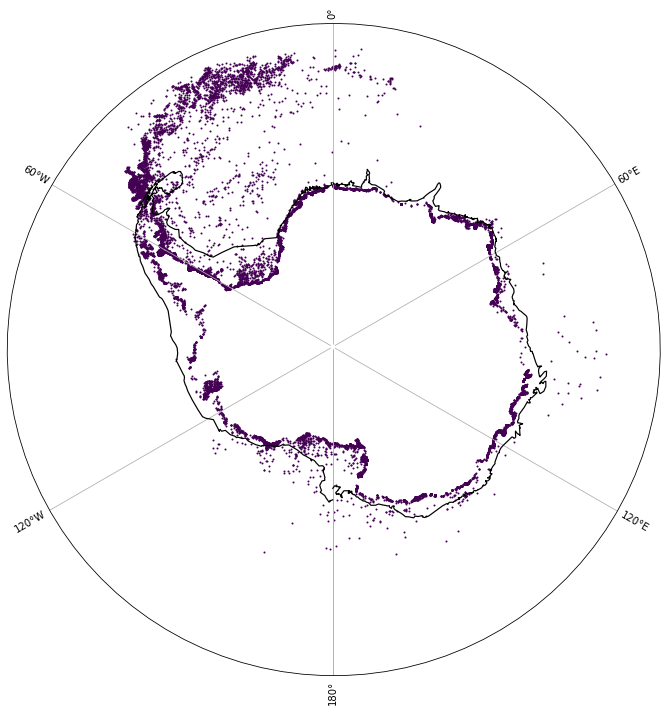

In [11]:
fig, ax = prepare_plot()
for num in iceberg_numbers:
    ax.scatter(icebergs['lon'][icebergs['iceberg_number'][:,0]==num], 
               icebergs['lat'][icebergs['iceberg_number'][:,0]==num], 
               c=icebergs['year'][icebergs['iceberg_number'][:,0]==num], s=1, transform=ccrs.PlateCarree())

ax.plot(x_iso1, y_iso1, c='k', zorder=4, linewidth=1.2, transform=ccrs.PlateCarree())
ax.plot(x_iso2, y_iso2, c='k', zorder=4, linewidth=1.2, transform=ccrs.PlateCarree())